In [149]:
import networkx as nx
import numpy as np
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random
import shapely

from typing import Dict, List, Optional, Self, Tuple

EPS = 1e-3  # Error tolerance for some geometric operations.

In [150]:
def generate_square(len: float) -> shapely.Polygon:
    """Returns a square polygon that its width and length are `len`.

    Args:
        len (float): Length of a square.

    Returns:
        shapely.Polygon: Generated square centered at origin.
    """
    return shapely.Polygon(
        (
            (len / 2, len / 2),
            (len / 2, -len / 2),
            (-len / 2, -len / 2),
            (-len / 2, len / 2),
            (len / 2, len / 2),
        )
    )

In [151]:
def rotate_and_translate(
    g: shapely.geometry, theta: float, x: float, y: float
) -> shapely.geometry:
    """Rotates and then translates the given geometry `g`.

    Args:
        g (shapely.geometry): Geometry to be rotated and translated.
        theta (float): Rotation angle (degree).
        x (float): Translation along x-axis.
        y (float): Translation along y-axis.

    Returns:
        shapely.geometry: Rotated and translated geometry.
    """
    return shapely.affinity.translate(shapely.affinity.rotate(g, theta), x, y)

In [152]:
def segment_to_vector(ls: shapely.LineString) -> np.ndarray:
    """Converts a line segment to a vector.

    Args:
        ls (shapely.LineString): Line segment.

    Returns:
        np.ndarray: Direction vector of the line segment.
    """
    return np.array(
        [ls.coords[1][0] - ls.coords[0][0], ls.coords[1][1] - ls.coords[0][1]]
    )

In [153]:
def is_cw(ls: shapely.LineString, p: shapely.Point) -> bool:
    """Returns true if `p` is on the clockwise side of `ls`.

    Args:
        ls (shapely.LineString): Linestring.
        p (shapely.Point): Point.

    Returns:
        bool: True if clockwise
    """
    return (
        np.cross(
            segment_to_vector(ls),
            np.array([p.x - ls.coords[0][0], p.y - ls.coords[0][1]]),
        )
        < 0
    )

In [154]:
def compute_acute_angle(p: shapely.Point, q: shapely.Point, r: shapely.Point) -> float:
    """Computes the acute angle between p, q, and r.

    Args:
        p (shapely.Point): Point p.
        q (shapely.Point): Point q.
        r (shapely.Point): Point r.

    Returns:
        float: Acute angle between p, q, and r.
    """
    pq = np.array([q.x - p.x, q.y - p.y])
    rq = np.array([q.x - r.x, q.y - r.y])
    angle = math.atan2(np.cross(pq, rq), np.dot(pq, rq))
    return abs(angle)

In [155]:
def generate_world(config: Dict) -> Dict[str, shapely.Geometry]:
    """Generates a world depicted by the given `config`.

    Args:
        config (Dict): Configuration of the world.
        e.g.,
        {
            "seed"      : 0,
            "obstacles" : {
                "number_of_squares" : 10,
                "length_range"      : (1.0, 5.0),
                "theta_range"       : (0.0, 360.0),
                "x_range"           : (10.0, 90.0),
                "y_range"           : (10.0, 90.0)
            }
        }

    Returns:
        Dict[str, shapely.Geometry]: Generated world.
        e.g.,
        {
            "obstacles" : shapely.MultiPolygon,
        }
    """
    random.seed(config["seed"])
    squares = [
        rotate_and_translate(
            generate_square(random.uniform(*config["obstacles"]["length_range"])),
            random.uniform(*config["obstacles"]["theta_range"]),
            random.uniform(*config["obstacles"]["x_range"]),
            random.uniform(*config["obstacles"]["y_range"]),
        )
        for _ in range(config["obstacles"]["number_of_squares"])
    ]
    union = shapely.union_all(squares)
    if union.geom_type == "Polygon":
        union = shapely.GeometryCollection((union))
    polygons = []
    for geom in union.geoms:
        polygons.append(shapely.Polygon(geom.exterior.coords))
    return {
        "obstacles": shapely.MultiPolygon(polygons),
    }

In [156]:
def draw_world(
    world: Dict[str, shapely.Geometry],
    graph: shapely.MultiLineString = shapely.MultiLineString(()),
):
    """Draws the given world and visibility graph.

    Args:
        world (Dict[str, shapely.Geometry]): World.
        e.g.,
        {
            "obstacles" : shapely.MultiPolygon,
        }
        graph (shapely.MultiLineString): Edges of visibility graph.
    """
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = world["obstacles"].bounds
    ax.set_xlim(xmin - 10, xmax + 10)
    ax.set_ylim(ymin - 10, ymax + 10)
    for obstacle in world["obstacles"].geoms:
        ax.add_patch(
            patches.Polygon(
                obstacle.exterior.coords,
                fc="green",
                lw=1.0,
                color="black",
                ls="--",
                alpha=0.5,
            )
        )
    for edge in graph.geoms:
        ax.plot(*edge.coords.xy, color="blue", lw=1.0)
    ax.set_aspect("equal")
    fig.tight_layout()
    plt.show()

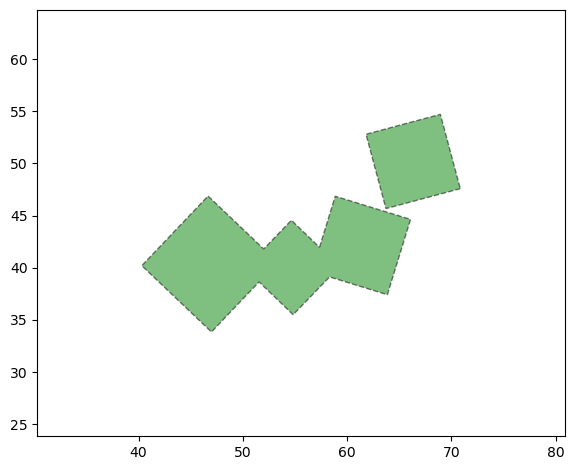

In [157]:
example_world = generate_world(
    {
        "seed": 0,
        "obstacles": {
            "number_of_squares": 4,
            "length_range": (5.0, 10.0),
            "theta_range": (0.0, 180.0),
            "x_range": (30.0, 70.0),
            "y_range": (30.0, 70.0),
        },
    }
)
draw_world(example_world)

In [158]:
def construct_visibility_graph_naively(
    world: Dict[str, shapely.Geometry]
) -> List[shapely.LineString]:
    """Constructs a visibility graph using a naive algorithm.

    Args:
        world (Dict[str, shapely.Geometry]): World.
        e.g.,
        {
            "obstacles" : shapely.MultiPolygon,
        }

    Returns:
        List[shapely.LineString]: Edges of the generated visibility graph.
    """
    polygons = world["obstacles"]
    points = []
    for polygon in polygons.geoms:
        points.extend([shapely.Point(point) for point in polygon.exterior.coords[:-1]])

    graph = []
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            ls = shapely.LineString((points[i], points[j]))
            if polygons.boundary.contains(ls) or ls.touches(polygons):
                graph.append(ls)

    return shapely.MultiLineString(graph)

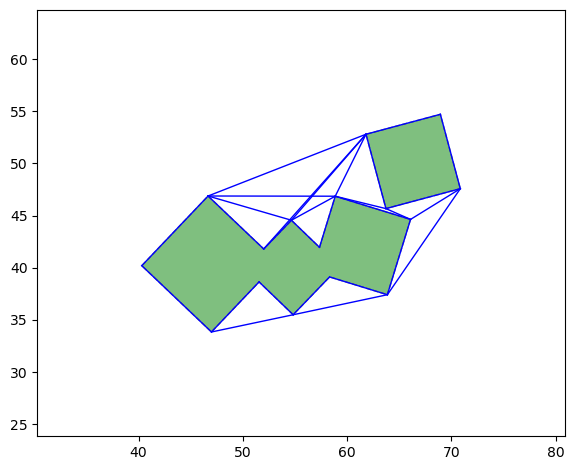

In [159]:
draw_world(example_world, construct_visibility_graph_naively(example_world))

In [160]:
def construct_visibility_graph_efficiently(
    world: Dict[str, shapely.Geometry]
) -> List[shapely.LineString]:
    """Constructs a visibility graph using an efficient algorithm.

    Args:
        world (Dict[str, shapely.Geometry]): World.
        e.g.,
        {
            "obstacles" : shapely.MultiPolygon,
        }

    Returns:
        List[shapely.LineString]: Edges of the generated visibility graph.
    """
    polygons = world["obstacles"]
    polygon_graph = build_polygon_graph(polygons)

    points = []
    for polygon in polygons.geoms:
        points.extend([shapely.Point(point) for point in polygon.exterior.coords[:-1]])

    visibility_graph = []
    for point in points:
        for q in get_visible_points(point, polygon_graph, polygons):
            visibility_graph.append(shapely.LineString((point, q)))

    return shapely.MultiLineString(visibility_graph)

In [161]:
def build_polygon_graph(polygons: shapely.MultiPolygon) -> nx.Graph:
    """Builds a graph of which the vertices are points, and the edges are the sides.

    Args:
        polygons (shapely.MultiPolygon): Obstacles.

    Returns:
        nx.Graph: A graph representing the polygons.
    """
    id = 0
    graph = nx.Graph()
    for polygon in polygons.geoms:
        offset = id
        for i in range(len(polygon.exterior.coords) - 1):
            graph.add_node(id, id=id, coord=shapely.Point(polygon.exterior.coords[i]))
            id += 1
        for i in range(len(polygon.exterior.coords) - 2):
            graph.add_edge(offset + i, offset + i + 1)
        graph.add_edge(offset, offset + len(polygon.exterior.coords) - 2)
    return graph

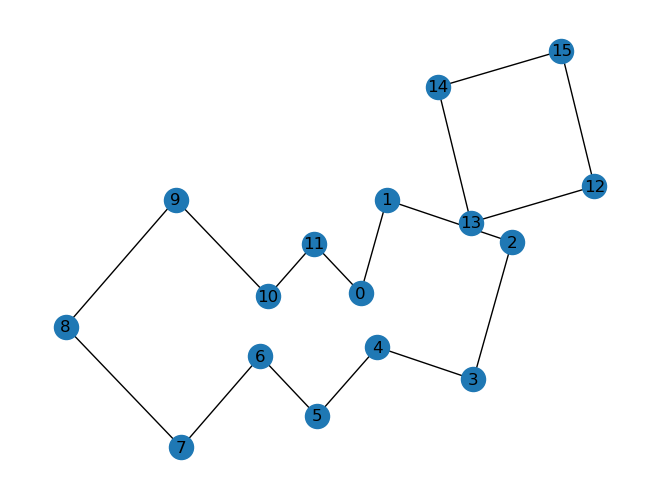

In [162]:
example_polygon_graph = build_polygon_graph(example_world["obstacles"])
nx.draw(
    example_polygon_graph,
    pos={
        node[1]["id"]: node[1]["coord"].coords[0]
        for node in example_polygon_graph.nodes(data=True)
    },
    with_labels=True,
)

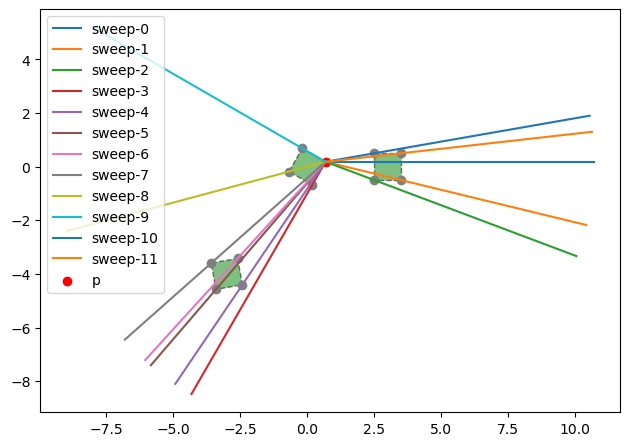

In [163]:
# DO NOT COPY THIS.
def scan_example(polygons):
    def my_atan2(p: shapely.Point, q: shapely.Point) -> float:
        theta = math.atan2(q.y - p.y, q.x - p.x)
        theta = -theta if theta < 0 else 2 * math.pi - theta
        return theta

    pts = []
    for polygon in polygons.geoms:
        pts.extend([shapely.Point(pt) for pt in polygon.exterior.coords[:-1]])
    p = pts[1]
    pts.sort(
        key=lambda q: (
            my_atan2(p, q),
            math.hypot(q.x - p.x, q.y - p.y),
        )
    )

    fig, ax = plt.subplots()
    for obstacle in polygons.geoms:
        ax.add_patch(
            patches.Polygon(
                obstacle.exterior.coords,
                fc="green",
                lw=1.0,
                color="black",
                ls="--",
                alpha=0.5,
            )
        )
    plt.plot([p.x, p.x + 10], [p.y, p.y], label="sweep-0", alpha=1.0)
    for i, q in enumerate(pts):
        if p == q:
            continue
        src = np.array([p.x, p.y])
        dst = np.array([q.x, q.y])
        dst = src + 10 * ((dst - src) / np.linalg.norm(dst - src))
        plt.plot([src[0], dst[0]], [src[1], dst[1]], label=f"sweep-{i+1}", alpha=1.0)
        plt.scatter(q.x, q.y, color="gray")

    plt.scatter(p.x, p.y, color="red", label="p")
    ax.set_aspect("equal")
    fig.tight_layout()
    plt.legend()
    plt.show()


fig_polygons = shapely.MultiPolygon(
    (
        rotate_and_translate(
            shapely.Polygon(((0.5, 0.5), (0.5, -0.5), (-0.5, -0.5), (-0.5, 0.5))),
            60,
            0,
            0,
        ),
        rotate_and_translate(
            shapely.Polygon(((0.5, 0.5), (0.5, -0.5), (-0.5, -0.5), (-0.5, 0.5))),
            0,
            3,
            0,
        ),
        rotate_and_translate(
            shapely.Polygon(((0.5, 0.5), (0.5, -0.5), (-0.5, -0.5), (-0.5, 0.5))),
            10,
            -3,
            -4,
        ),
    )
)

scan_example(fig_polygons)

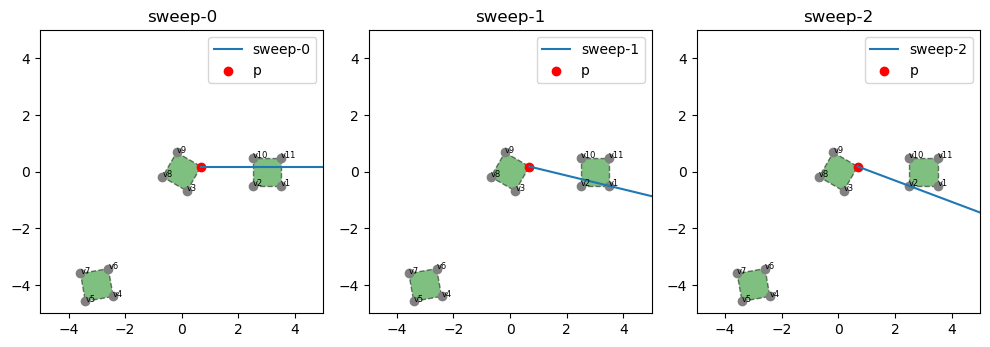

In [164]:
# DO NOT COPT THIS CODE BLOCK.
def candidate_sides_example(polygons):
    def my_atan2(p: shapely.Point, q: shapely.Point) -> float:
        theta = math.atan2(q.y - p.y, q.x - p.x)
        theta = -theta if theta < 0 else 2 * math.pi - theta
        return theta

    pts = []
    for polygon in polygons.geoms:
        pts.extend([shapely.Point(pt) for pt in polygon.exterior.coords[:-1]])
    p = pts[1]
    pts.sort(
        key=lambda q: (
            my_atan2(p, q),
            math.hypot(q.x - p.x, q.y - p.y),
        )
    )

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    for obstacle in polygons.geoms:
        for i in range(3):
            ax[i].add_patch(
                patches.Polygon(
                    obstacle.exterior.coords,
                    fc="green",
                    lw=1.0,
                    color="black",
                    ls="--",
                    alpha=0.5,
                )
            )
    ax[0].plot([p.x, p.x + 10], [p.y, p.y], label="sweep-0", alpha=1.0)
    for i, q in enumerate(pts):
        if p == q:
            continue
        if i < 2:
            src = np.array([p.x, p.y])
            dst = np.array([q.x, q.y])
            dst = src + 10 * ((dst - src) / np.linalg.norm(dst - src))
            ax[i + 1].plot(
                [src[0], dst[0]], [src[1], dst[1]], label=f"sweep-{i+1}", alpha=1.0
            )
        for k in range(3):
            ax[k].scatter(q.x, q.y, color="gray")
            ax[k].text(q.x, q.y, f"v{i + 1}", fontsize=6)

    for i in range(3):
        ax[i].scatter(p.x, p.y, color="red", label="p")
        ax[i].set_aspect("equal")
        ax[i].set_xlim([-5, 5])
        ax[i].set_ylim([-5, 5])
        ax[i].legend()
        ax[i].set_title(f"sweep-{i}")
    fig.tight_layout()
    plt.show()


candidate_sides_example(fig_polygons)

In [165]:
class Side:
    """A class representing a side of a polygon (i.e, binaty tree node)."""

    def __init__(self, src_id: int, dst_id: int, polygon_graph: nx.Graph):
        """C'tor.

        Args:
            src_id (int): ID of source vertex.
            dst_id (int): ID of destination vertex.
            polygon_graph (nx.Graph): A graph representing polygons.
        """
        if src_id > dst_id:
            self.__init__(dst_id, src_id, polygon_graph)
            return
        self.src_id = src_id
        self.dst_id = dst_id
        self.side = shapely.LineString(
            (polygon_graph.nodes[src_id]["coord"], polygon_graph.nodes[dst_id]["coord"])
        )
        self.left = None
        self.right = None

    def is_equal(self, rhs: Self) -> bool:
        """Returns whether the `rhs` is equals to `self`.

        Args:
            rhs (Self): A side.

        Returns:
            bool: True if `self` and `rhs` are equal.
        """
        return self.src_id == rhs.src_id and self.dst_id == rhs.dst_id

    def is_less_equal(self, sweep_line: shapely.LineString, rhs: Self) -> bool:
        """Returns whether `self <= rhs` on the given `sweep_line`.

        Args:
            sweep_line (shapely.LineString): A sweep line.
            rhs (Self): A side.

        Returns:
            bool: Whether `self <= rhs` on the given `sweep_line`.
        """
        if self.is_equal(rhs):
            return True

        def get_intersection(
            side: shapely.LineString, sweep_line: shapely.LineString
        ) -> Tuple[Optional[float], Optional[shapely.Point]]:
            p = sweep_line.coords[0]
            min_length = None
            min_intersection = None
            intersections = sweep_line.intersection(side, grid_size=EPS)
            if intersections.geom_type == "MultiLineString":
                for g in intersections.geoms:
                    for intersect in g.coords:
                        intersect = shapely.Point(intersect)
                        length = intersect.distance(shapely.Point(p))
                        if min_length is None or length < min_length:
                            min_length = length
                            min_intersection = intersect
            else:
                for intersect in intersections.coords:
                    intersect = shapely.Point(intersect)
                    length = intersect.distance(shapely.Point(p))
                    if min_length is None or length < min_length:
                        min_length = length
                        min_intersection = intersect
            return min_length, min_intersection

        length_self, intersection_self = get_intersection(self.side, sweep_line)
        length_rhs, intersection_rhs = get_intersection(rhs.side, sweep_line)

        if abs(length_self - length_rhs) > EPS:
            return length_self <= length_rhs

        self_end = (
            self.side.coords[0]
            if shapely.Point(self.side.coords[1]).distance(
                shapely.Point(intersection_self)
            )
            < EPS
            else self.side.coords[1]
        )
        rhs_end = (
            rhs.side.coords[0]
            if shapely.Point(rhs.side.coords[1]).distance(
                shapely.Point(intersection_rhs)
            )
            < EPS
            else rhs.side.coords[1]
        )

        return compute_acute_angle(
            shapely.Point(sweep_line.coords[0]),
            shapely.Point(intersection_self),
            shapely.Point(self_end),
        ) <= compute_acute_angle(
            shapely.Point(sweep_line.coords[0]),
            shapely.Point(intersection_self),
            shapely.Point(rhs_end),
        )

In [166]:
class CandidateSides:
    """A class for candidate sides (i.e., binary tree)."""

    def __init__(self):
        """C'tor."""
        self.root = None

    def get_min(self) -> Optional[Side]:
        """Gets the minimum side.

        Returns:
            Side: The minimum side.
        """
        return self._get_min(self.root)

    def _get_min(self, root: Optional[Side]) -> Optional[Side]:
        """Gets the minimum side from a tree rooted at `root`.

        Args:
            root (Optional[Side]): A root.

        Returns:
            Optional[Side]: The minimum side.
        """
        if root is not None and root.left is not None:
            return self._get_min(root.left)
        else:
            return root

    def get_max(self) -> Optional[Side]:
        """Gets the maximum side.

        Returns:
            Side: The maximum side.
        """
        return self._get_max(self.root)

    def _get_max(self, root: Optional[Side]) -> Optional[Side]:
        """Gets the maximum side from a tree rooted at `root`.

        Args:
            root (Optional[Side]): A root.

        Returns:
            Optional[Side]: The maximum side.
        """
        if root is not None and root.right is not None:
            return self._get_max(root.right)
        else:
            return root

    def insert(self, sweep_line: shapely.LineString, side: Side) -> Side:
        """Inserts a side to the tree.

        Args:
            sweep_line (shapely.LineString): A sweep line.
            side (Side): A side to insert.

        Returns:
            Side: A root of inserted tree.
        """
        self.root = self._insert(sweep_line, self.root, side)
        return self.root

    def _insert(
        self, sweep_line: shapely.LineString, root: Optional[Side], side: Side
    ) -> Side:
        """Inserts a side to the tree.

        Args:
            sweep_line (shapely.LineString): A sweep line.
            root (Optional[Side]): A root.
            side (Side): A side to insert.

        Returns:
            Side: A root of inserted tree.
        """
        if root is None:
            root = side
        elif side.is_less_equal(sweep_line, root):
            root.left = self._insert(sweep_line, root.left, side)
        else:
            root.right = self._insert(sweep_line, root.right, side)
        return root

    def delete(self, sweep_line: shapely.LineString, side: Side) -> Optional[Side]:
        """Deletes a side from the tree.

        Args:
            sweep_line (shapely.LineString): A sweep line.
            side (Side): Side to delete.

        Returns:
            Optional[Side]: A root of deleted tree.
        """
        self.root = self._delete(sweep_line, self.root, side)
        return self.root

    def _delete(
        self, sweep_line: shapely.LineString, root: Optional[Side], side: Side
    ) -> Optional[Side]:
        """Deletes a side from the tree.

        Args:
            sweep_line (shapely.LineString): A sweep line.
            root (Optional[Side]): A root.
            side (Side): Side to delete.

        Returns:
            Optional[Side]: A root of deleted tree.
        """
        if root is None:
            return None
        elif root.is_equal(side):
            if root.left is None:
                return root.right
            elif root.right is None:
                return root.left
            else:
                max_side = self._get_max(root.left)
                root.src_id = max_side.src_id
                root.dst_id = max_side.dst_id
                root.side = max_side.side
                root.left = self._delete(sweep_line, root.left, max_side)
                return root
        elif root.is_less_equal(sweep_line, side):
            root.right = self._delete(sweep_line, root.right, side)
            return root
        else:
            root.left = self._delete(sweep_line, root.left, side)
            return root

    def traverse(self):
        """Inorder traverse."""
        self._traverse(self.root)

    def _traverse(self, root: Optional[Side], level: int = 0):
        """Inorder traverse of the tree rooted at `root`.

        Args:
            root (Optional[Side]): A root.
            level (int): Level of the root.
        """
        depth = ""
        for _ in range(level + 3):
            depth += "  "
        if root is None:
            print(depth + "NULL")
            return
        self._traverse(root.left, level + 1)
        print(f"{depth}: {root.src_id} -> {root.dst_id}")
        self._traverse(root.right, level + 1)

In [167]:
def get_visible_points(
    p: shapely.Point, polygon_graph: nx.Graph, polygons: shapely.MultiPolygon
) -> shapely.MultiPoint:
    """Returns points that are visible from `p`.

    Args:
        p (shapely.Point): A point.
        polygon_graph (nx.Graph): A polygon graph.
        polygons (shapely.MultiPolygon): Obstacles.

    Returns:
        shapely.MultiPoint: Visible points.
    """

    def my_atan2(p: shapely.Point, q: shapely.Point) -> float:
        theta = math.atan2(q.y - p.y, q.x - p.x)
        theta = -theta if theta <= 0 else 2 * math.pi - theta
        return theta

    # Sort vertices by clockwise order.
    nodes = []
    for n in polygon_graph.nodes:
        if p.distance(polygon_graph.nodes[n]["coord"]) > EPS:
            nodes.append(polygon_graph.nodes[n])
    nodes.sort(
        key=lambda q: (
            my_atan2(p, q["coord"]),
            math.hypot(q["coord"].x - p.x, q["coord"].y - p.y),
        )
    )

    def make_sweep_line(
        p: shapely.Point, q: shapely.Point, length: float = 1e3
    ) -> shapely.LineString:
        dir = np.array([q.x - p.x, q.y - p.y])
        dir *= length / np.linalg.norm(dir)
        return shapely.LineString((p, (p.x + dir[0], p.y + dir[1])))

    # Plane sweep.
    candidates = CandidateSides()

    # Initial sweep (positive x-axis direction).
    sweep_line = make_sweep_line(p, shapely.Point(p.x + 1, p.y))
    for src_id, dst_id in polygon_graph.edges:
        src = polygon_graph.nodes[src_id]["coord"]
        dst = polygon_graph.nodes[dst_id]["coord"]
        ls = shapely.LineString((src, dst))
        if sweep_line.crosses(ls):
            candidates.insert(sweep_line, Side(src_id, dst_id, polygon_graph))

    # Sweep in the clockwise order.
    visible_points = []
    for node in nodes:
        sweep_line = make_sweep_line(p, node["coord"])
        min_side = candidates.get_min()
        ls = shapely.LineString((p, node["coord"]))
        if min_side is None and not polygons.contains(ls):
            visible_points.append(node["coord"])
        elif not polygons.contains(ls):
            intersections = sweep_line.intersection(min_side.side, grid_size=EPS)
            if intersections.geom_type != "MultiLineString":
                intersections = intersections.coords
                if len(intersections) == 0:
                    visible_points.append(node["coord"])
                elif (
                    len(intersections) == 1
                    and shapely.Point(intersections[0]).distance(node["coord"]) < EPS
                ):
                    visible_points.append(node["coord"])
        for neighbor in polygon_graph.neighbors(node["id"]):
            side = Side(node["id"], polygon_graph.nodes[neighbor]["id"], polygon_graph)
            if is_cw(sweep_line, polygon_graph.nodes[neighbor]["coord"]):
                candidates.insert(sweep_line, side)
            else:
                candidates.delete(sweep_line, side)

    return visible_points

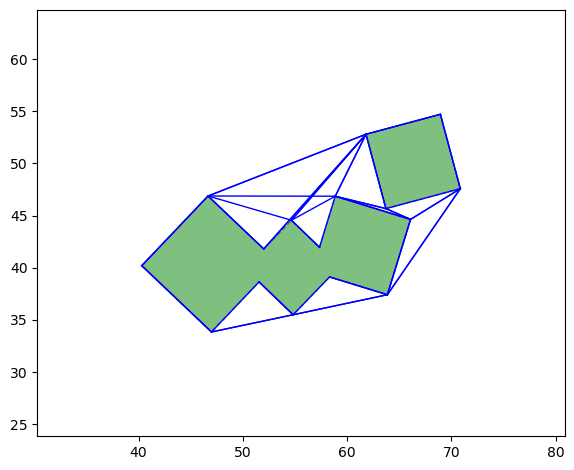

In [168]:
draw_world(example_world, construct_visibility_graph_efficiently(example_world))

In [ ]:
import time

data = []
for npolygons in range(10, 101, 20):
    world = generate_world(
        {
            "seed": 2,
            "obstacles": {
                "number_of_squares": npolygons,
                "length_range": (1.0, 10.0),
                "theta_range": (0.0, 180.0),
                "x_range": (10.0, 90.0),
                "y_range": (10.0, 90.0),
            },
        }
    )

    tick = time.time()
    # visibility_graph_naive = construct_visibility_graph_naively(world)
    tock = time.time()
    naive_time_msec = (tock - tick) * 1e3

    tick = time.time()
    visibility_graph_efficient = construct_visibility_graph_efficiently(world)
    tock = time.time()
    efficient_time_msec = (tock - tick) * 1e3
    
    print(f"Number of Polygons: {npolygons}")

    data.append([npolygons, naive_time_msec, efficient_time_msec])

plt.title("Visibility Graph Construction Time")
plt.xlabel("Number of Polygons")
plt.ylabel("Time (msec)")
plt.plot([d[0] for d in data], [d[1] for d in data], label="Naive")
plt.plot([d[0] for d in data], [d[2] for d in data], label="Efficient")
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'